# EY Data Challenge: Predicting Urban Heat Islands

This is the submission for the EY 2025 Data Science Challenege where we attempted to assess the Urban Heat Island Effect in New York City. In this project, we placed 86th out of 2076 teams in the world with an accuracy of 0.9606 on the test data. In this notebook, you will see the entire data collection, EDA, feature engineering, and model development that achieved our final model score.

##### Packages
A variety of geospatial, data processing and mathematical packages are required to run this program.

In [1]:
# Machine Learning
from sklearn.ensemble import RandomForestRegressor

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Data Science Packages
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import common GIS tools
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Geospatial raster data handling
import rioxarray as rxr

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Others
import os
from tqdm import tqdm

# ckdTree for mapping 
from scipy.spatial import cKDTree

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load


# set the number of columns we see
pd.set_option('display.max_columns',None)

# EY Data Set
EY was the creator of this data challenge, they provided contestants with 11229 training data points with 1040 test data points. The goal is to create a submission which has the highest correlation amongst the test data points they have kept and our predicted UHI values.

## Loading the EY Data

### UHI Training Data
The training data was collected at differnet locations on July 24th 2021 across Manhattan and the Bronx. This data is used for training our model. It allows us to visualize where certain hot spots can be identified on the map.

In [2]:
uhi_train = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/ey_dataset/Training_data_uhi_index_2025-02-18.csv')
uhi_train.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


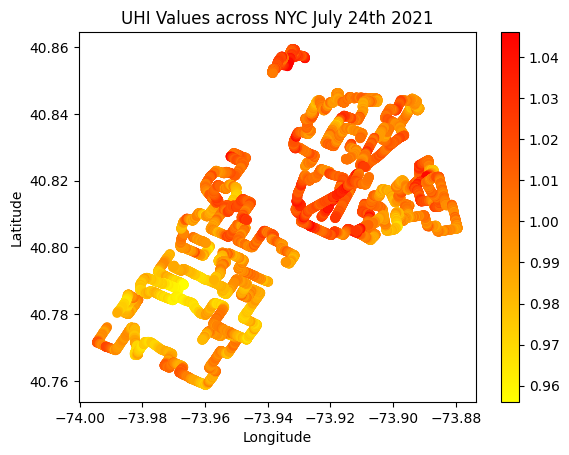

In [3]:
plt.scatter(uhi_train['Longitude'],uhi_train['Latitude'],c=uhi_train['UHI Index'],cmap='autumn_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('UHI Values across NYC July 24th 2021')
plt.colorbar()

- UHI values range from 0.96 to 1.04. These values are calculated from looing at the specific temperature relative to the average of the city.
- The cooler areas are around Central Park while warmer areas tend to be in the Bronx.

### UHI Testing Data
The test data from EY had similar proximity to the training data but we were not given the UHI values and the goal of this notebook is to create a model to predict these values.

In [4]:
uhi_test = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/ey_dataset/Submission_template.csv')
uhi_test.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


Text(0.5, 1.0, 'Test Data Locations')

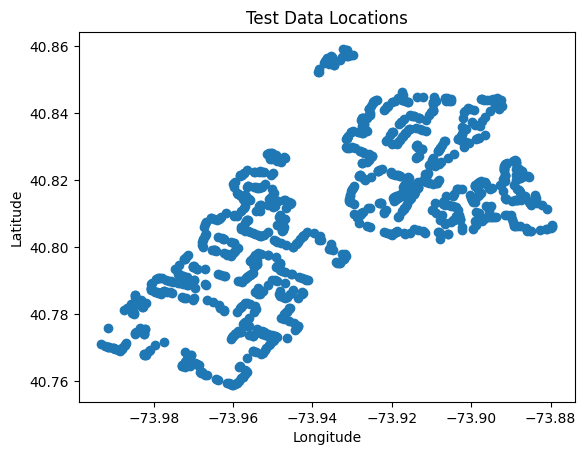

In [5]:
plt.scatter(uhi_test['Longitude'],uhi_test['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Test Data Locations')

It is clear that the test data and the training data have relatively similar data points just with small differences in the long/lat points which surprisngly still show differences in temperatures.

# Satellite Imagery Creation
Satellite imagery was an essential component of this project, it allowed us to incorporate multiple satellite data to utilize computer vision techniques to make sense of the land that can be seen from above. This chapter is going to explore which satellites we used and for what reason.

Information about all satellites can be found here at the Microsoft Planetary Computer - https://planetarycomputer.microsoft.com/

##### Functions
A variety of functions were used in the creation of satellite imagery as this was a repeated process.

In [6]:
# create a function that can collect satellite data
def create_xarray_data(location, date_range, satellite, cloud_coverage, bands, resolution):
    """ 
    Fetch Sentinel-2 imagery as an xarray dataset.

    Parameters:
    - location: Tuple (min_lon, min_lat, max_lon, max_lat) defining the bounding box.
    - date_range: String in 'YYYY-MM-DD/YYYY-MM-DD' format defining the time window.
    - satellite: Name of the satellite collection (e.g., 'sentinel-2-l2a').
    - cloud_coverage: Max cloud cover percentage (integer, e.g., 30 for <30% clouds).
    - bands: List of band names (e.g., ['B02', 'B03', 'B04'] for RGB).
    - resolution: Desired spatial resolution in meters (e.g., 10m for Sentinel-2).

    Returns:
    - xarray.Dataset containing the requested satellite data.
    """

    # Define bounding box
    # Connect to Microsoft Planetary Computer STAC API
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


    # Search for matching satellite imagery
    search = stac.search(
        bbox=location, 
        datetime=date_range,
        collections=[satellite],
        query={"eo:cloud_cover": {"lt": cloud_coverage}},
    )

    # Convert search results to a list
    items = list(search.get_items())
    print(f'Satellite Images Found: {len(items)}')

    if not items:
        raise ValueError("No STAC items found for the given parameters.")

    # Sign the items for access
    signed_items = [planetary_computer.sign(item) for item in items]

    # Load data using stackstac
    data = stac_load(
        signed_items,
        bands=bands,
        crs="EPSG:4326",  # Latitude-Longitude
        resolution=resolution / 111320.0,  # Ensure resolution is in meters
        chunks={"x": 2048, "y": 2048},  # Optimize chunking
        dtype="uint16",
        patch_url=planetary_computer.sign,
        bbox=location
    )

    return data


In [7]:
def sentinel_1_xarray(location,date_range,satellite,bands):
    # Step 1: Connect to the Planetary Computer STAC API
    catalog_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(catalog_url)

    # Step 2: Define your search parameters
    time_range = "2021-07-26/2021-07-26"  # Up to current date, July 26th 2021

    search = catalog.search(
        collections=[satellite],  # Sentinel-1 GRD product
        bbox=location,
        datetime=date_range,
        limit=10
    )

    # Step 3: Retrieve the items
    items = list(search.items())
    print(f"Found {len(items)} Sentinel-1 scenes.")

    signed_items = [planetary_computer.sign(item).to_dict() for item in items]

        # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees
    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 

    # 'items' is a list of STAC Items from a prior search (e.g., via pystac_client)
    sentinel_1_july_26th = stac_load(
        items,                           # STAC Items from Sentinel-1 GRD search
        bands=bands,             # Sentinel-1 polarization bands
        crs="EPSG:4326",                # Latitude-Longitude coordinate system
        resolution=scale,               # Degrees (set 'scale' to desired resolution, e.g., 0.0001 for ~10 m)
        chunks={"x": 2048, "y": 2048},  # Dask chunks for lazy loading
        dtype="uint16",                 # GRD data typically uint16 (check metadata if float32 needed)
        patch_url=planetary_computer.sign,  # Sign URLs for Planetary Computer access
        bbox=location                     # Bounding box in EPSG:4326 [min_lon, min_lat, max_lon, max_lat]
    )

    return sentinel_1_july_26th

In [8]:
import os

def output_file(filename, image_data, bounds, bands, location):
    """
    Saves a multi-band raster (GeoTIFF) from an xarray dataset.

    Parameters:
    - filename (str): Name of the output file (e.g., "output.tif").
    - image_data (xarray.DataArray or xarray.Dataset): The dataset containing band data.
    - bounds (tuple): Bounding box (min_lon, min_lat, max_lon, max_lat).
    - bands (list): List of band names to include in the output file.

    Returns:
    - None (Saves the GeoTIFF file)
    """

    filename = os.path.join(location, filename)
    
    # Extract width and height from dataset dimensions
    height = image_data.dims["latitude"]
    width = image_data.dims["longitude"]
    
    # Create raster transform using bounding box
    gt = rasterio.transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    # Assign CRS and transform to the dataset
    image_data.rio.write_crs("epsg:4326", inplace=True)
    image_data.rio.write_transform(transform=gt, inplace=True)

    # Create GeoTIFF output file
    with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                       crs='epsg:4326', transform=gt, count=len(bands),
                       compress='lzw', dtype='float64') as dst:
        for i, band in enumerate(bands):
            dst.write(image_data[band].values, i + 1)  # Ensure NumPy array format

    print(f"GeoTIFF saved: {filename}")

In [9]:
# function to create a median mosaic
def median_mosaic(data):
    median = data.median(dim='time').compute()
    return median

## Sentinel 2 Satellite Data
- Location - NYC
- Time Window - Summer 2021
- Satellite - Sentinel 2
- Cloud Coverage - <30%
- Bands - ("B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12")

Sentinel 2 satellite is a polar orbiting satellite and has a 5 day revisit time which allows time series data to be collect of the Earth. We are going to collect a series of images from the summer of 2021 to identify statistically average band values, this is done by taking a median mosaic.

In [10]:
nyc_location = (-74.00, 40.75, -73.87, 40.86) # Bounding box for NYC
summer_2021 = "2021-06-01/2021-09-01"         # Summer 2021
satellite = "sentinel-2-l2a"                  # Sentinel-2 Level 2A
cloud_coverage = 30                           # Max 30% cloud cover
sentinel_2_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"] # Sentinel 2 Bands
resolution = 10 # Resolution of 10m      

summer_sentinel_2_xarray = create_xarray_data(nyc_location,summer_2021,satellite,cloud_coverage,sentinel_2_bands,resolution)

Satellite Images Found: 10


Using Microsoft planetary computer we are able to fetch an xarray data format where we have 10 dates of sentinel 2 band data in the proximity of NYC. These values can now be changed for any location on the Earth to identify Urban Heat Islands.

In [11]:
# now lets created a median mosaic
# this is done to remove clouds which may impact the sentinel 2 values
# known as statistically removing clouds
summer_sentinel_2 = median_mosaic(summer_sentinel_2_xarray)

In [12]:
output_file('sentinel_2_summer.tiff',summer_sentinel_2,nyc_location,summer_sentinel_2,'/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images')

GeoTIFF saved: /Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images/sentinel_2_summer.tiff


After statistically removing the clouds we created a tiff file which can be used later in this notebook to load in satellite imagery data.

### Sentinel 1 Data
- Location - NYC
- Time Window - July 26th 2021
- Satellite - Sentinel 1
- Cloud Coverage - 10
- Sentinel 1 - (vv,vh)
- Resolution - 30

The sentinel 1 satellite is a part of the European Union Copernicus and is another satellite which is useful in tracking climate changes across the globe. We are going to be interested in two of their bands VV and VH which are used to capture bare soil in imagery.

In [13]:
nyc_location = (-74.00, 40.75, -73.87, 40.86) # Bounding box for NYC
sentinel_1_date = '2021-06-01/2021-09-01'     # Sentinel 1 date
sentinel_1 = "sentinel-1-grd"                 # Sentinel-1 GRD
low_cloud_coverage = 0                        # Max 10% cloud cover
sentinel_1_all_bands = ['vv','vh']            # Sentinel 1 bands
resolution = 10                               # 10m resolution

sentinel_1_summer_xarray = sentinel_1_xarray(nyc_location,sentinel_1_date,sentinel_1,sentinel_1_all_bands)

Found 7 Sentinel-1 scenes.


We are going to be using another median mosaic for the summer of 2021.

In [14]:
sentinel_1_summer = median_mosaic(sentinel_1_summer_xarray)

In [15]:
output_file('sentinel_1_07_26.tiff',sentinel_1_summer,nyc_location,sentinel_1_all_bands,'/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images')

GeoTIFF saved: /Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images/sentinel_1_07_26.tiff


### Landsat Data
- Location - NYC
- Time Window - Summer 2021
- Satellite - Landsat 8
- Cloud Coverage - 30
- Bands - (lwir11,red,green,blue,nir08)
- Resolution - 30

The landsat 8 satellite is a sun-synchronous near polar orbit and specialzes in thermal infrared sennsors and operational land imager.

#### Thermal
We are going to be using May 15th as the thermal data as the temperature most closely matched with the temperature on July 24th which was the day of the training (there was no thermal data for July 24th)

In [16]:
nyc_location = (-74.00, 40.75, -73.87, 40.86)  # Bounding box for NYC
landsat_date = "2021-05-15/2021-05-15"         # Landsat date - closest temperature to test data
landsat = "landsat-c2-l2"                      # Landsat 8 Satellite
cloud_coverage = 30                            # Max 30% cloud cover
thermal_bands = ["lwir11"]                     # landsat bands
resolution = 10                                # 10m resolution

landsat_thermal_05_may_xarray = create_xarray_data(nyc_location,landsat_date,landsat,cloud_coverage,thermal_bands,resolution)

Satellite Images Found: 1


In [17]:
landsat_thermal_05_may = median_mosaic(landsat_thermal_05_may_xarray)

In [18]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
landsat_thermal_05_may = landsat_thermal_05_may.astype(float) * scale2 + offset2 - kelvin_celsius

The above scaling is done to turn the lwir11 values into temperature in degrees celsius, this showed strong improvements in this satellite data in model creation.

In [19]:
output_file('landsat_thermal_05_may.tiff',landsat_thermal_05_may,nyc_location,thermal_bands,'/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images')

GeoTIFF saved: /Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images/landsat_thermal_05_may.tiff


#### Non Thermal Bands

In [20]:
nyc_location = (-74.00, 40.75, -73.87, 40.86)  # Bounding box for NYC
landsat_summer_date = "2021-06-01/2021-09-01"  # Landsat Summer Date
landsat = "landsat-c2-l2"                      # Landsat 8 Satellite
cloud_coverage = 30                            # Max 30% cloud cover
non_thermal_bands = ['red','blue','green','nir08'] # landsat bands
resolution = 10    

landsat_non_thermal_05_may_xarray = create_xarray_data(nyc_location,landsat_summer_date,landsat,cloud_coverage,non_thermal_bands,resolution)

Satellite Images Found: 13


In [21]:
landsat_non_thermal_05_may = median_mosaic(landsat_non_thermal_05_may_xarray)

In [22]:
# Scale Factors for the RGB and NIR bands
scale1 = 0.0000275
offset1 = -0.2
landsat_thermal_05_may_xarray[['red','blue','green','nir08']] = landsat_non_thermal_05_may[['red','blue','green','nir08']].astype(float) * scale1 + offset1

Furthr scaling done for the other band values.

In [23]:
output_file('landsat_non_thermal_05_may.tiff', landsat_non_thermal_05_may, nyc_location, non_thermal_bands,'/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images')

GeoTIFF saved: /Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images/landsat_non_thermal_05_may.tiff


We now have tiff files for all of the satellite data that is required for our model building. They can be found in the 'satellite_images' folder.

# NYC Data
NYC Open Data is an open source collection of data that can be used for public use.

We will be looking at building elevation apart of the planmetric tracking of data as well as natural elevation apart of the Building Elevation and Subgrade.

The full NYC open data source can be found here - https://opendata.cityofnewyork.us/

##### Functions

In [24]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the nearest elevation value to the UHI dataset using a KDTree for fast nearest-neighbor search.
    
    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing UHI data with 'Latitude' and 'Longitude' columns.
        elevation_data (pd.DataFrame): DataFrame containing elevation data with 'Latitude', 'Longitude', and 'z_grade' columns.

    Returns:
        pd.DataFrame: UHI dataset with an added 'Elevation' column.
    """
    # Extract coordinates from both datasets
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree for fast nearest-neighbor search
    tree = cKDTree(elevation_coords)
    
    # Find the nearest elevation point for each UHI point
    distances, indices = tree.query(uhi_coords)
    
    # Add the matched elevation values to the UHI dataset
    uhi_data = uhi_data.copy()

    for col in data_to_map.drop(columns=['Longitude','Latitude']):
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

In [25]:
def create_rounded_data(data):
    
    # convert the data to float values
    data = data.astype(float)

    # round by 3 decimal places
    data[['Longitude','Latitude']] = data[['Longitude','Latitude']].round(3)

    # group by the similar long/lat
    data = data.groupby(['Longitude','Latitude']).median().reset_index()

    return data

## Building Elevation Data
Building elevation was found using planimetric data and selecting the feature code '3020' as that was the highest point from the ground. The original data has not been included in the github repo due to the size of the data.


### Granular Elevation Data
Throughout this project we are going to compare granular and proximity data this is an extremely successful effort in generalizing the model to be applicable to data points not seen before.

In [26]:
building_elevation = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/building_elevation_edit_original.csv',index_col=0)

In [27]:
# the area below has been commented out to reduce runtimes
"""
# load the data
building_elevation_original = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/planimetric_building_elevation.csv')

# create a dataframe
building_elevation = pd.DataFrame()

# get the longitude and latitude using string detection
building_elevation[['Longitude','Latitude']] = building_elevation_original['the_geom'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)')

# add relevant columns
building_elevation[['Feature Code','Building Elevation']] = building_elevation_original[['FEAT_CODE','ELEVATION']]

# save building elevation as an integer value
building_elevation = building_elevation_original.astype(float)

# 3020 is the code used for building elevation
building_elevation = building_elevation[building_elevation['Feature Code'] == 3020]
building_elevation = building_elevation.drop(columns='Feature Code')

# convert the height from feet to meters
building_elevation['Building Elevation'] = building_elevation['Building Elevation']*0.328084

# get the specific data used from the training data
long_min,long_max,lat_min,lat_max = nyc_location

manhattan_bronx_area = (
    building_elevation['Longitude'].between(long_min,long_max) &
    building_elevation['Latitude'].between(lat_min,lat_max)
)

# use the boolean mask to update building elevation
building_elevation = building_elevation[manhattan_bronx_area]

building_elevation.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/building_elevation_edit_original.csv')
"""

"\n# load the data\nbuilding_elevation_original = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/planimetric_building_elevation.csv')\n\n# create a dataframe\nbuilding_elevation = pd.DataFrame()\n\n# get the longitude and latitude using string detection\nbuilding_elevation[['Longitude','Latitude']] = building_elevation_original['the_geom'].str.extract(r'POINT \\((-?\\d+\\.\\d+) (-?\\d+\\.\\d+)\\)')\n\n# add relevant columns\nbuilding_elevation[['Feature Code','Building Elevation']] = building_elevation_original[['FEAT_CODE','ELEVATION']]\n\n# save building elevation as an integer value\nbuilding_elevation = building_elevation_original.astype(float)\n\n# 3020 is the code used for building elevation\nbuilding_elevation = building_elevation[building_elevation['Feature Code'] == 3020]\nbuilding_elevation = building_elevation.drop(columns='Feature Code')\n\n# convert the height from feet to meters\nbuilding_elevation['Building Elevation'] = building_ele

In [28]:
# lets look at the building elevation data in meters
building_elevation.head()

,Longitude,Latitude,Building Elevation
84,-73.943214,40.652620,19.714568
97,-73.925203,40.619571,14.120735
98,-73.932564,40.619576,13.320210
102,-73.930605,40.619578,15.291995
103,-73.932095,40.619580,9.146982


In [29]:
building_elevation.shape

(846271, 3)

We have 846271 building elevation data points which can be used in our model building

Text(0, 0.5, 'Latitude')

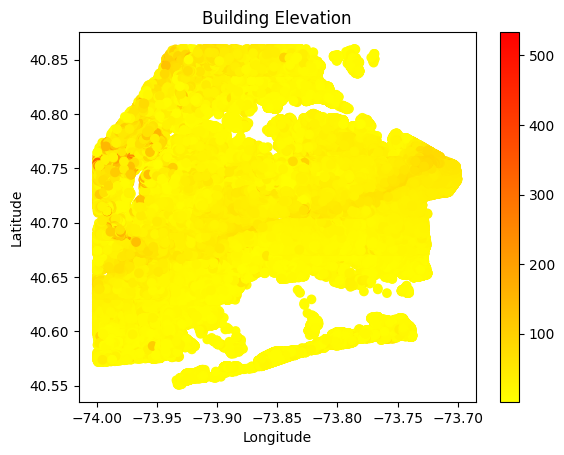

In [30]:
plt.scatter(building_elevation['Longitude'],building_elevation['Latitude'],c=building_elevation['Building Elevation'],cmap='autumn_r')
plt.title('Building Elevation')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Proximity Building Elevation Data
Using proximity elevation is going to be achieved using a grid-like manipulation of values. We are going to round our data to three decimal places and then get the median value of all of the points with the same long/lat values, this essentially creates a spatial proximity rather than a granular one.

In [31]:
# use the create rounded data to create proximity data
building_elevation_proximity = create_rounded_data(building_elevation)

building_elevation_proximity.head()

,Longitude,Latitude,Building Elevation
0,-74.0,40.573,51.984910
1,-74.0,40.574,33.812331
2,-74.0,40.575,13.421916
3,-74.0,40.578,23.202100
4,-74.0,40.580,22.982367


In [32]:
building_elevation_proximity.shape

(45652, 3)

We can see that we have reduced the number of data points drastically to only about 45000 data points. By using a grid we have now collected multiple points into one proximity (around 100 meters) and using the average building elevation of that proximity.

Text(0, 0.5, 'Latitude')

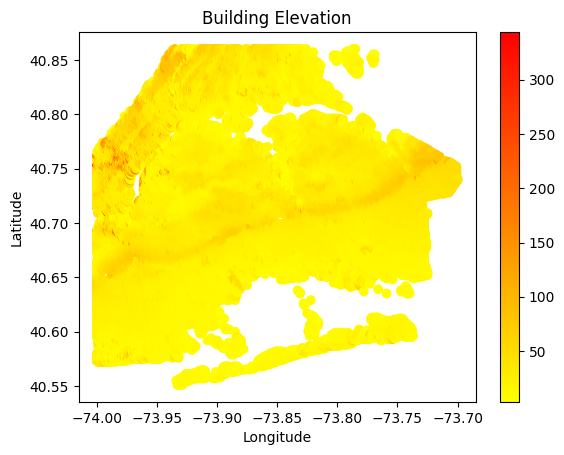

In [33]:
plt.scatter(building_elevation_proximity['Longitude'],building_elevation_proximity['Latitude'],c=building_elevation_proximity['Building Elevation'],cmap='autumn_r')
plt.title('Building Elevation')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [34]:
# save the building elevation proximity to be used in training process
building_elevation_proximity.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/nyc_data/building_elevation_proximity.csv')

In [35]:
building_elevation_proximity_data = add_nearest_data(uhi_train,building_elevation_proximity)

building_elevation_proximity_data.head()

,Longitude,Latitude,datetime,UHI Index,Building Elevation
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,20.410106
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,20.410106
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,20.410106
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,20.410106
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,20.410106


In [36]:
building_elevation_proximity_data.shape

(11229, 5)

We can see that using the add_nearest_data function we have mapped the training data to the nearest building elevation values. This mapping has made a successfuly creation of proximity based values, where there will be multiple values in close proximity with the same median building elevation value.

## Natural Elevation
The same process for building elevation is going to be repeated for natural elevation.

### Granular Natural Elevation

In [37]:
# the below was the process of editing the original data 
# this has been done to not include the large original file to upload to github repo

"""
# load in natural elevation
natural_elevation = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/natural_elevation.csv')

# get the relevant columns
natural_elevation[['Longitude','Latitude','Natural Elevation']] = natural_elevation[['longitude','latitude','z_grade']]

natural_elevation = natural_elevation[['Longitude','Latitude','Natural Elevation']]

# convert the elevation to meters instead of feat
natural_elevation['Natural Elevation'] = natural_elevation['Natural Elevation'] * 0.328084

natural_elevation.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/natural_elevation_edit_original.csv')

"""

"\n# load in natural elevation\nnatural_elevation = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/natural_elevation.csv')\n\n# get the relevant columns\nnatural_elevation[['Longitude','Latitude','Natural Elevation']] = natural_elevation[['longitude','latitude','z_grade']]\n\nnatural_elevation = natural_elevation[['Longitude','Latitude','Natural Elevation']]\n\n# convert the elevation to meters instead of feat\nnatural_elevation['Natural Elevation'] = natural_elevation['Natural Elevation'] * 0.328084\n\nnatural_elevation.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/natural_elevation_edit_original.csv')\n\n"

In [38]:
natural_elevation = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/original_data/natural_elevation_edit_original.csv',index_col=0)

In [39]:
print(natural_elevation.shape)
natural_elevation.head()

(861876, 3)


,Longitude,Latitude,Natural Elevation
0,-74.215896,40.549105,21.480316
1,-74.149890,40.630853,9.635827
2,-74.037379,40.631601,9.468832
3,-74.010281,40.606650,7.280840
4,-74.000341,40.611148,10.878281


We have around 861k natural elevation heights to work with.

### Proximity Natural Elevation

In [40]:
# create rounded data using the function
natural_elevation_proximity = create_rounded_data(natural_elevation)

Text(0, 0.5, 'Latitude')

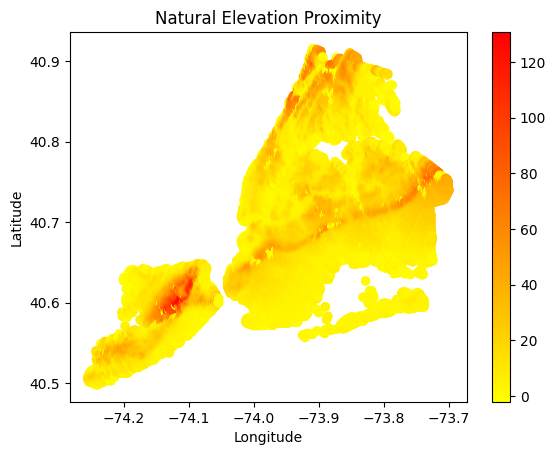

In [41]:
plt.scatter(natural_elevation_proximity['Longitude'],natural_elevation_proximity['Latitude'],c=natural_elevation_proximity['Natural Elevation'],cmap='autumn_r')
plt.title('Natural Elevation Proximity')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

We can see how the rounded has made a more general shade to indicated the differences in natural elevation.

In [42]:
natural_elevation_proximity.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/nyc_data/natural_elevation_proximity.csv')

In [43]:
natural_elevation_proximity_data = add_nearest_data(uhi_train,natural_elevation_proximity) 

print(natural_elevation_proximity_data.shape)
natural_elevation_proximity_data.head()

(11229, 5)


,Longitude,Latitude,datetime,UHI Index,Natural Elevation
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,11.393045
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,11.393045
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,11.393045
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,11.393045
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,11.393045


We have again mapped the uhi training values natural elevation proximity points, this is done to improve the robustness of the model.

# Loading Satellite Data
As we load in satellite data, we want to perform a similar activity as elevation data where we use a proximity to get values of data to use. However, when we are working with 11229 training data points, it is not enough to create proximity data which is accurate so we are going to artifically create noise in the creation of satellite data.

1. Add random noise to the training long/lat points
2. Map the band values to the noisy long/lat
3. Round the long/lat to 3 places 
4. Group by the long/lat
5. Get the median of those with similar long/lat
6. Now we have about 1500 median data points 
7. Map training long/lat to the 1500 median data points (nearest point)
8. Map the test long/lat to the 1500 data points (nearest point)

When we have this data we can map whatever training data we have to the nearest proximity data point to get the most generalized version of a data point.

##### Functions

In [44]:
def map_satellite_data(tiff_path,training_data, band_names):
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the CSV file
    latitudes = training_data['Latitude'].values
    longitudes = training_data['Longitude'].values

    # Convert lat/long to the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  
    proj_tiff = Proj(tiff_crs)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Reproject coordinates
    transformed_coords = [transformer.transform(lat, lon) for lat, lon in zip(latitudes, longitudes)]
    xs, ys = zip(*transformed_coords)

    # Get available band numbers
    band_numbers = data.coords["band"].values
    
    # Validate that the user provided the correct number of band names
    if len(band_names) != len(band_numbers):
        raise ValueError(f"Expected {len(band_numbers)} band names, but got {len(band_names)}")

    # Dictionary to store extracted band values
    band_data = {band_name: [] for band_name in band_names}

    # Extract values for each band
    for x, y in tqdm(zip(xs, ys), total=len(xs), desc="Extracting band values"):
        for band, band_name in zip(band_numbers, band_names):
            value = data.sel(x=x, y=y, band=band, method="nearest").values
            band_data[band_name].append(value)

    # Convert dictionary to DataFrame
    return pd.DataFrame(band_data)

In [45]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [46]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the nearest elevation value to the UHI dataset using a KDTree for fast nearest-neighbor search.
    
    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing UHI data with 'Latitude' and 'Longitude' columns.
        elevation_data (pd.DataFrame): DataFrame containing elevation data with 'Latitude', 'Longitude', and 'z_grade' columns.

    Returns:
        pd.DataFrame: UHI dataset with an added 'Elevation' column.
    """
    # Extract coordinates from both datasets
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree for fast nearest-neighbor search
    tree = cKDTree(elevation_coords)
    
    # Find the nearest elevation point for each UHI point
    distances, indices = tree.query(uhi_coords)
    
    # Add the matched elevation values to the UHI dataset
    uhi_data = uhi_data.copy()

    for col in data_to_map.drop(columns=['Longitude','Latitude']):
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

In [47]:
def create_rounded_data(data):
    
    # convert the data to float values
    data = data.astype(float)

    # round by 3 decimal places
    data[['Longitude','Latitude']] = data[['Longitude','Latitude']].round(3)

    # group by the similar long/lat
    data = data.groupby(['Longitude','Latitude']).median().reset_index()

    return data

In [48]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the nearest elevation value to the UHI dataset using a KDTree for fast nearest-neighbor search.
    
    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing UHI data with 'Latitude' and 'Longitude' columns.
        elevation_data (pd.DataFrame): DataFrame containing elevation data with 'Latitude', 'Longitude', and 'z_grade' columns.

    Returns:
        pd.DataFrame: UHI dataset with an added 'Elevation' column.
    """
    # Extract coordinates from both datasets
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree for fast nearest-neighbor search
    tree = cKDTree(elevation_coords)
    
    # Find the nearest elevation point for each UHI point
    distances, indices = tree.query(uhi_coords)
    
    # Add the matched elevation values to the UHI dataset
    uhi_data = uhi_data.copy()

    for col in data_to_map.drop(columns=['Longitude','Latitude']):
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

## Create Noise
We are going to add 5 points of noise around data with a standard deviation of 0.0001 for each long/lat value, this will allow us to generalize values to reduce outliers impacting model.

In [49]:
# let's create a funciton that creates random noise for a single point
def generate_noise(long,lat,proximity_points,std=0.0001):
    lat_noisy = lat + np.random.normal(0,std,proximity_points)
    long_noisy = long + np.random.normal(0,std,proximity_points)

    return list(zip(long_noisy, lat_noisy))

In [50]:
sentinel_long_noisy = []
sentinel_lat_noisy = []

for _,row in uhi_train.iterrows():
    long = row['Longitude']
    lat = row['Latitude']

    noise = generate_noise(long,lat,5)
    for i,row in enumerate(noise):
        sentinel_long_noisy.append(noise[i][0])
        sentinel_lat_noisy.append(noise[i][1])


# create a new df
proximity_uhi_train = pd.DataFrame({'Longitude':sentinel_long_noisy,'Latitude':sentinel_lat_noisy})

proximity_uhi_train

,Longitude,Latitude
0,-73.909286,40.813262
1,-73.908911,40.813063
2,-73.909148,40.813195
3,-73.909154,40.813167
4,-73.909087,40.813123
...,...,...
56140,-73.957121,40.790018
56141,-73.957147,40.790136
56142,-73.957201,40.790115
56143,-73.957060,40.789932


We can see that there has been an additional 5 points added to each location and we can now map created satellite data to these points.

## Load Sentinel 2 Data
The process of creating the satellite data has been commented out to reduce runtimes of the notebook, to run youreself, remove the hashtags!

### Load Noisy Data

In [51]:
# load the data in
#sentinel_2_summer_data = map_satellite_data('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images/sentinel_2_summer.tiff',proximity_uhi_train,sentinel_2_bands)

#sentinel_2_summer_data

In [52]:
# combine long/lat
#sentinel_2_proximity_data = combine_two_datasets(proximity_uhi_train,sentinel_2_summer_data)

#sentinel_2_proximity_data = create_rounded_data(sentinel_2_proximity_data)

In [53]:
#sentinel_2_proximity_data.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/satellite_data/sentinel_2_proximity_data.csv')

In [54]:
sentinel_2_proximity_data = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/satellite_data/sentinel_2_proximity_data.csv',index_col=0)

sentinel_2_proximity_data.head()

,Longitude,Latitude,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,-73.995,40.771,1112.0,1761.0,1983.0,2101.0,1991.00,1993.50,2096.5,2198.0,2077.5,2048.0,1881.0
1,-73.995,40.772,1112.0,1418.0,1595.0,1721.5,1680.00,1720.00,1744.0,1765.5,1741.5,1841.0,1732.5
2,-73.994,40.771,1392.5,1409.0,1558.0,1782.0,1922.50,1872.50,1915.0,1922.0,1936.0,2080.5,1942.5
3,-73.994,40.772,1365.0,1411.0,1554.0,1674.0,1772.00,1817.00,1858.0,1725.0,1792.5,1904.5,1786.0
4,-73.994,40.773,1275.0,1359.5,1507.0,1617.5,1801.75,1736.25,1807.0,1757.0,1852.5,1861.0,1638.0


We now have 1569 rounded grouped data points that can be used in the training of our model. Similar to elevation points they are used as reference for robust data point selections.

### Map Noisy Data
Get the nearest uhi training value from the noisy median data.

In [55]:
sentinel_2_proximity_uhi_train = add_nearest_data(uhi_train, sentinel_2_proximity_data)
sentinel_2_proximity_uhi_train.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5


By using the add_nearest_data function we use a ckdtree to find the nearest data value of the UHI training point to the rounded long/lat.

## Load Sentinel 1 Data

### Load Noisy Data

In [56]:
#sentinel_1_summer_proximity = map_satellite_data('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images/sentinel_1_07_26.tiff',proximity_uhi_train,sentinel_1_all_bands)

#sentinel_1_summer_proximity.head()

In [57]:
# combine long/lat
#sentinel_1_proximity_data = combine_two_datasets(proximity_uhi_train,sentinel_1_summer_proximity)

#sentinel_1_proximity_data = create_rounded_data(sentinel_1_proximity_data)

#sentinel_1_proximity_data.head()

### Map Noisy Data

In [58]:
#sentinel_1_proximity_uhi_train = add_nearest_data(uhi_train,sentinel_1_proximity_data)

#sentinel_1_proximity_uhi_train.head()

In [59]:
#sentinel_1_proximity_uhi_train.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/satellite_data/sentinel_1_proximity_data.csv')

In [60]:
# load in the above data which has been rounded and mapped
sentinel_1_proximity_data = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/satellite_data/sentinel_1_proximity_data.csv',index_col=0)

sentinel_1_proximity_data.head()

,Longitude,Latitude,datetime,UHI Index,vv,vh
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,331.0,183.0
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,331.0,183.0
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,331.0,183.0
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,331.0,183.0
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,331.0,183.0


## Load Landsat 8 Data

### Thermal Data

In [61]:
#landsat_thermal_05_may_granular = map_satellite_data('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images/landsat_thermal_05_may.tiff',uhi_train,thermal_bands)

In [62]:
# combine long/lat
#landsat_thermal_data = combine_two_datasets(uhi_train,landsat_thermal_05_may_granular)

#landsat_thermal_data

In [63]:
#landsat_thermal_data.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/satellite_data/landsat_8_granular_data.csv')

In [64]:
landsat_thermal_granular_data = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/satellite_data/landsat_8_granular_data.csv',index_col=0)

landsat_thermal_granular_data.head()

,Longitude,Latitude,datetime,UHI Index,lwir11
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,37.091675
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,37.091675
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,37.091675
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,37.091675
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,36.760128


As we are using the granular version of the thermal heat data we are going not going to use add nearest data as we are not using proximity values.

### Non Thermal Data

In [65]:
#landsat_non_thermal_summer_granular = map_satellite_data('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/satellite_images/landsat_non_thermal_05_may.tiff',proximity_uhi_train,non_thermal_bands)

In [66]:
# combine long/lat
#landsat_non_thermal_data = combine_two_datasets(proximity_uhi_train,landsat_non_thermal_summer_granular)

#landsat_non_thermal_data.head()

In [67]:
#landsat_non_thermal_proximity = create_rounded_data(landsat_non_thermal_data) 

#landsat_non_thermal_proximity_data = add_nearest_data(uhi_train,landsat_non_thermal_proximity)

In [68]:
#landsat_non_thermal_proximity_data.to_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/satellite_data/landsat_8_non_thermal_proximity_data.csv')

In [69]:
landsat_non_thermal_proximity_data = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/urban_heat_islands/created_data/satellite_data/landsat_8_non_thermal_proximity_data.csv',index_col=0)

landsat_non_thermal_proximity_data.head()

,Longitude,Latitude,datetime,UHI Index,red,blue,green,nir08
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,10534.0,9832.0,10535.0,14392.0
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,10534.0,9832.0,10535.0,14392.0
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,10534.0,9832.0,10535.0,14392.0
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,10534.0,9832.0,10535.0,14392.0
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,10534.0,9832.0,10535.0,14392.0


# Model Building
We have now created all of the data that is necessary 
- Sentinel 2 Summer 
- Sentinel 1 Summer
- Landsat 8 Thermal May 15th 
- Landsat 8 Non Thermal Summer
- Building Elevation
- Natural Elevation

##### Functions

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_ts, y_tr, y_pred_in, y_pred_out):
    """
    Evaluates a model's predictions using various evaluation methods.

    Parameters:
    - y_ts: Actual target values (test data)
    - y_tr: Actual target values (train data)
    - y_pred_in: Predicted values for training data (in-sample)
    - y_pred_out: Predicted values for test data (out-of-sample)

    Returns:
    - Dictionary with evaluation metrics: R² (train and test), MAE, MSE, RMSE
    """
    # Scatter plot of predicted vs test data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_ts, y_pred_out)
    plt.title('Predicted Values vs Test Data Values')
    plt.xlabel('Test UHI Values')
    plt.ylabel('Predicted UHI Values')

    # Residual plot
    residuals =  y_pred_out - y_ts
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_out, residuals)
    plt.title('Residuals of Predicted UHI Values')
    plt.xlabel('UHI Value')
    plt.ylabel('Residual')

    plt.tight_layout()
    plt.show()

    # R² scores for test and train data
    r2_test = r2_score(y_ts, y_pred_out)
    r2_train = r2_score(y_tr, y_pred_in)  # R² for train predictions

    print(f'R² Test Score (Out-of-Sample): {r2_test}')
    print(f'R² Train Score (In-Sample): {r2_train}')

    # Other Evaluation Metrics
    mae = mean_absolute_error(y_ts, y_pred_out)
    mse = mean_squared_error(y_ts, y_pred_out)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Returning evaluation metrics as a dictionary
    return {
        'R² Test': r2_test,
        'R² Train': r2_train,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }


## Load Data 

In [111]:
# create a dataframe 
X = pd.DataFrame()

# combine the data into one dataframe
X[sentinel_2_bands] = sentinel_2_proximity_uhi_train[sentinel_2_bands]
X[sentinel_1_all_bands] = sentinel_1_proximity_data[sentinel_1_all_bands]
X[thermal_bands] = landsat_thermal_granular_data[thermal_bands]
X[non_thermal_bands] = landsat_non_thermal_proximity_data[non_thermal_bands]
X['Building Elevation'] = building_elevation_proximity_data['Building Elevation']
X['Natural Elevation'] = natural_elevation_proximity_data['Natural Elevation']
X['Building Height Only'] = X['Building Elevation'] - X['Natural Elevation']

X.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,vv,vh,lwir11,red,blue,green,nir08,Building Elevation,Natural Elevation,Building Height Only
0,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5,331.0,183.0,37.091675,10534.0,9832.0,10535.0,14392.0,20.410106,11.393045,9.017061
1,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5,331.0,183.0,37.091675,10534.0,9832.0,10535.0,14392.0,20.410106,11.393045,9.017061
2,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5,331.0,183.0,37.091675,10534.0,9832.0,10535.0,14392.0,20.410106,11.393045,9.017061
3,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5,331.0,183.0,37.091675,10534.0,9832.0,10535.0,14392.0,20.410106,11.393045,9.017061
4,841.5,675.0,823.0,821.5,1212.0,1883.0,2117.5,2181.5,2251.0,1617.5,1305.5,331.0,183.0,36.760128,10534.0,9832.0,10535.0,14392.0,20.410106,11.393045,9.017061


In [112]:
# create the y values
y = uhi_train['UHI Index']

## Train/Test Split Data

In [116]:
# get the train and test split
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,test_size=0.2,random_state=42)

## Build Model

In [117]:
rf = RandomForestRegressor().fit(X_tr,y_tr)

y_pred_out = rf.predict(X_ts)
y_pred_in = rf.predict(X_tr)

## Evaluation

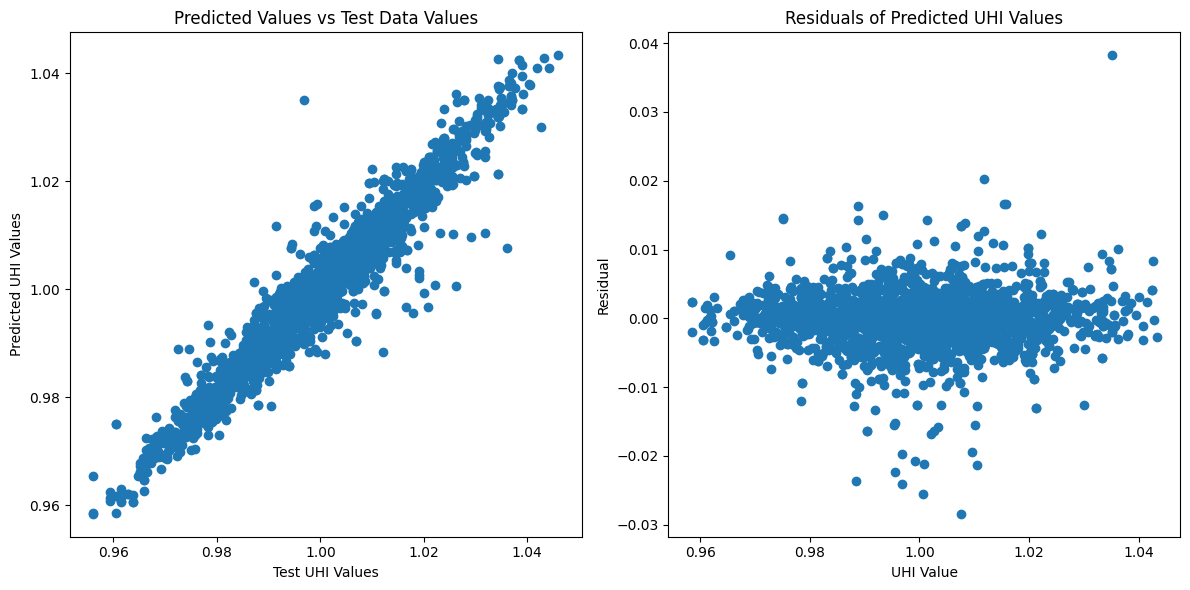

R² Test Score (Out-of-Sample): 0.9370313473271542
R² Train Score (In-Sample): 0.9818183768829158
Mean Absolute Error (MAE): 0.0027438315886073234
Mean Squared Error (MSE): 1.6554428223651005e-05
Root Mean Squared Error (RMSE): 0.004068713337610675


{'R² Test': 0.9370313473271542,
 'R² Train': 0.9818183768829158,
 'MAE': 0.0027438315886073234,
 'MSE': 1.6554428223651005e-05,
 'RMSE': 0.004068713337610675}

In [118]:
evaluate_model(y_ts,y_tr,y_pred_in,y_pred_out)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'B01'),
  Text(1, 0, 'B02'),
  Text(2, 0, 'B03'),
  Text(3, 0, 'B04'),
  Text(4, 0, 'B05'),
  Text(5, 0, 'B06'),
  Text(6, 0, 'B07'),
  Text(7, 0, 'B08'),
  Text(8, 0, 'B8A'),
  Text(9, 0, 'B11'),
  Text(10, 0, 'B12'),
  Text(11, 0, 'vv'),
  Text(12, 0, 'vh'),
  Text(13, 0, 'lwir11'),
  Text(14, 0, 'red'),
  Text(15, 0, 'blue'),
  Text(16, 0, 'green'),
  Text(17, 0, 'nir08'),
  Text(18, 0, 'Building Elevation'),
  Text(19, 0, 'Natural Elevation'),
  Text(20, 0, 'Building Height Only')])

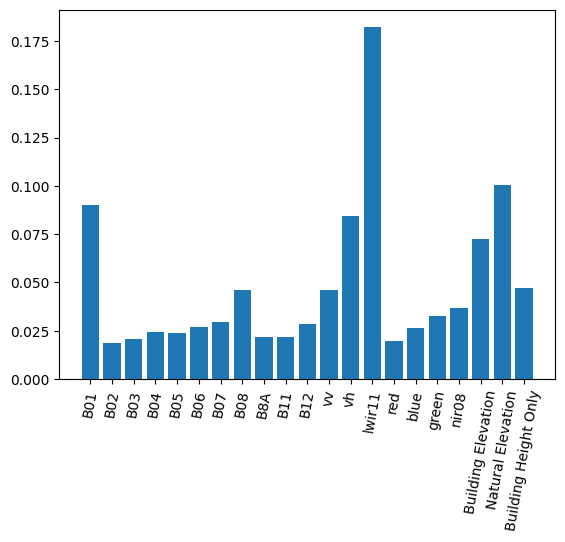

In [119]:
plt.bar(X.columns,rf.feature_importances_) 
plt.xticks(rotation=80)

## Hyperparameter Tuning

In [120]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# Define the hyperparameter search space
param_space = {
    'n_estimators': Integer(100, 500),  # Number of trees in the forest
    'max_depth': Integer(10, 40),  # Maximum depth of trees
    'min_samples_split': Integer(2, 10),  # Min samples to split an internal node
    'min_samples_leaf': Integer(1, 5),  # Min samples in a leaf node
    'max_features': Categorical([None, 'sqrt', 'log2']),  # Number of features per tree
    'bootstrap': Categorical([True, False])  # Whether to use bootstrapping
}

# Define Bayesian Search with 5-fold CV
bayes_search = BayesSearchCV(
    rf,  # Our base model
    param_space,  # The hyperparameter space
    n_iter=30,  # Number of optimization steps
    scoring='neg_mean_absolute_error',  # Optimize for MAE
    n_jobs=-1,  # Use all CPU cores
    random_state=42,
    verbose=1  # Show progress
)

# Run the search
bayes_search.fit(X_tr, y_tr)

# Extract the best parameters found
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [139]:
X_tr,X_ts,y_tr,y_ts = train_test_split(X,y,test_size=0.2,random_state =20)

In [142]:
rf_hyper_param = RandomForestRegressor(max_depth=37,max_features='log2',min_samples_leaf=1,min_samples_split=2,n_estimators=500).fit(X_tr,y_tr)

rf_hyper_param_in = rf_hyper_param.predict(X_tr)

rf_hyper_param_out = rf_hyper_param.predict(X_ts)

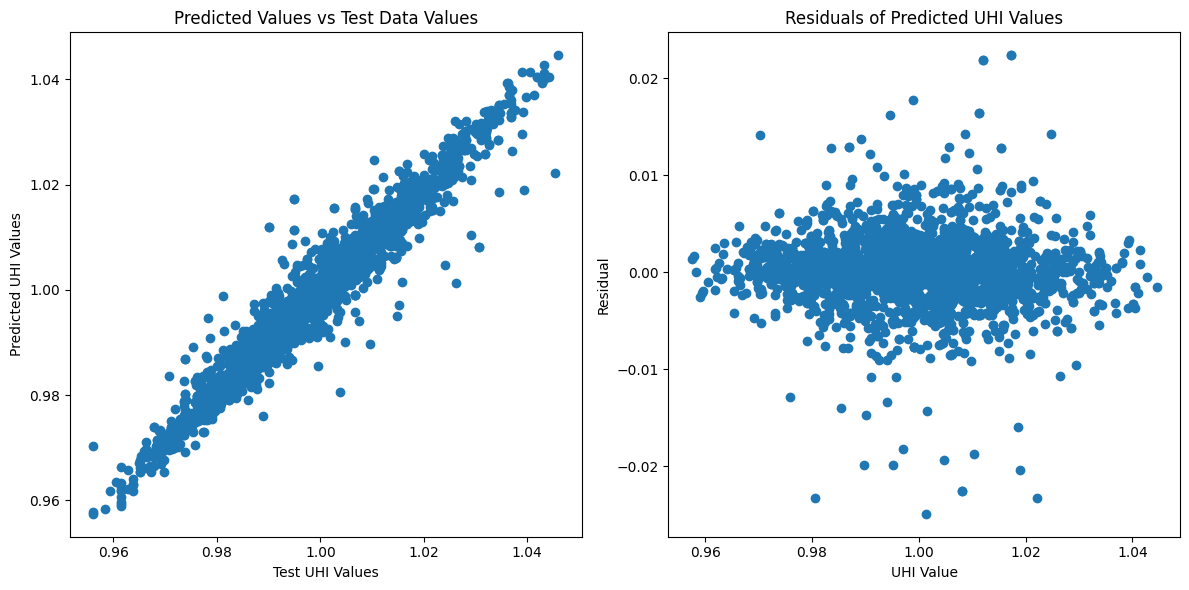

R² Test Score (Out-of-Sample): 0.9471153015092759
R² Train Score (In-Sample): 0.9823908704777858
Mean Absolute Error (MAE): 0.0025098127738626425
Mean Squared Error (MSE): 1.4180885698634883e-05
Root Mean Squared Error (RMSE): 0.003765751677770971


{'R² Test': 0.9471153015092759,
 'R² Train': 0.9823908704777858,
 'MAE': 0.0025098127738626425,
 'MSE': 1.4180885698634883e-05,
 'RMSE': 0.003765751677770971}

In [143]:
evaluate_model(y_ts,y_tr,rf_hyper_param_in,rf_hyper_param_out)

Text(0, 0.5, 'Importance')

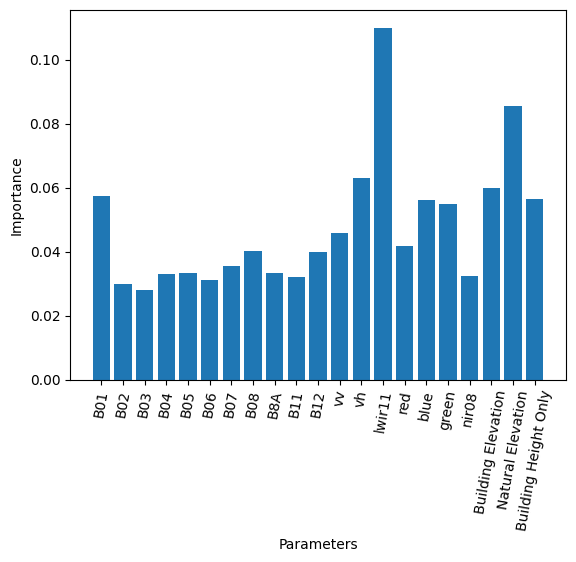

In [148]:
plt.bar(X.columns, rf_hyper_param.feature_importances_)
plt.xticks(rotation=80)
plt.xlabel('Parameters')
plt.ylabel('Importance')